<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/test_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook explains processing example 2D and 3D images using the Cellpose package on Google Colab using the GPU.

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

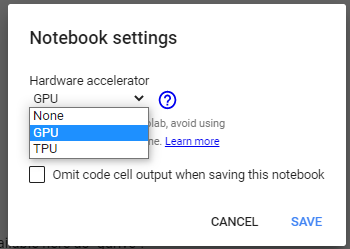

### Install Cellpose-SAM

In [1]:
# !pip install git+https://www.github.com/mouseland/cellpose.git

Check GPU and instantiate model - will download weights.

In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
print("GPU is", "available" if core.use_gpu() else "NOT AVAILABLE")

model = models.CellposeModel(gpu=True)

2025-12-01 21:09:46,162 [INFO] WRITING LOG OUTPUT TO /home/ads4015/.cellpose/run.log
2025-12-01 21:09:46,163 [INFO] 
cellpose version: 	4.0.7 
platform:       	linux 
python version: 	3.14.0 
torch version:  	2.9.1+cu128
2025-12-01 21:09:46,277 [INFO] ** TORCH CUDA version installed and working. **
GPU is available
2025-12-01 21:09:46,280 [INFO] ** TORCH CUDA version installed and working. **
2025-12-01 21:09:46,280 [INFO] >>>> using GPU (CUDA)
2025-12-01 21:09:47,922 [INFO] >>>> loading model /home/ads4015/.cellpose/models/cpsam


### Download example images

100%|██████████| 21.3M/21.3M [00:00<00:00, 62.2MB/s]
100%|██████████| 1.63M/1.63M [00:00<00:00, 24.4MB/s]


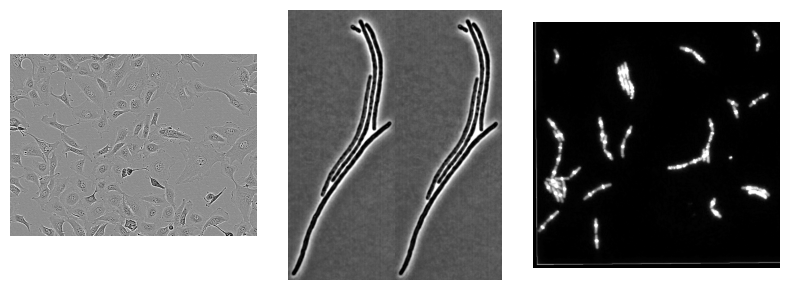

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import utils, io

# download example 2D images from website
url = "http://www.cellpose.org/static/data/imgs_cyto3.npz"
filename = "imgs_cyto3.npz"
utils.download_url_to_file(url, filename)

# download 3D tiff
url = "http://www.cellpose.org/static/data/rgb_3D.tif"
utils.download_url_to_file(url, "rgb_3D.tif")

dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["imgs"]
masks_true = dat["masks_true"]

plt.figure(figsize=(8,3))
for i, iex in enumerate([9, 16, 21]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img[0], cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Run Cellpose-SAM

In [3]:
masks_pred, flows, styles = model.eval(imgs, niter=1000) # using more iterations for bacteria


2025-12-01 21:10:30,620 [INFO] 100%|##########| 24/24 [00:11<00:00,  2.04it/s]


plot results

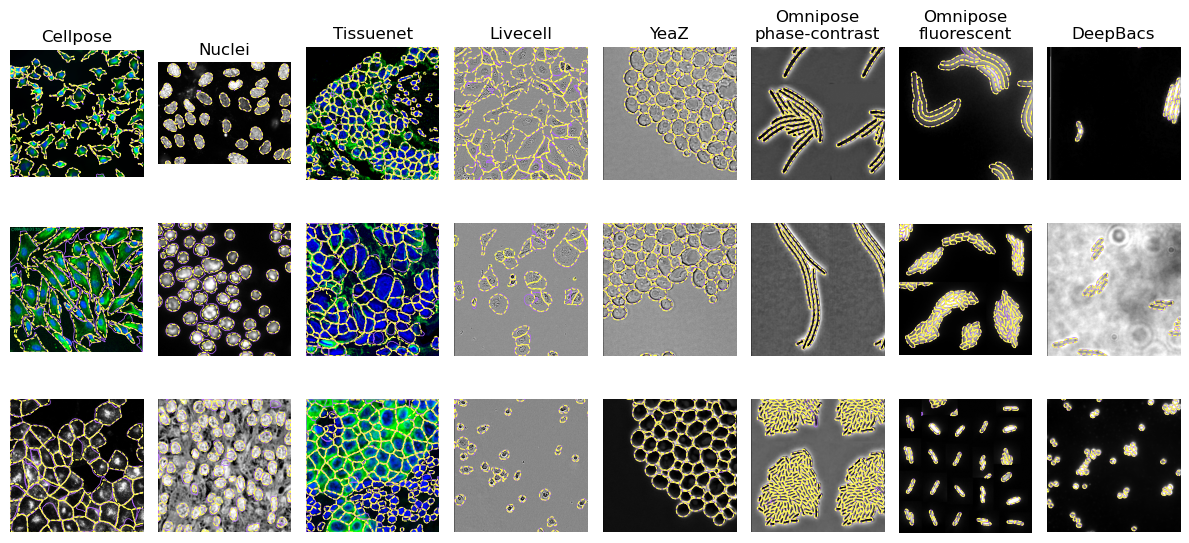

In [4]:
from cellpose import transforms, plot

titles = [
        "Cellpose", "Nuclei", "Tissuenet", "Livecell", "YeaZ",
         "Omnipose\nphase-contrast", "Omnipose\nfluorescent",
        "DeepBacs"
    ]

plt.figure(figsize=(12,6))
ly = 400
for iex in range(len(imgs)):
    img = imgs[iex].squeeze().copy()
    img = np.clip(transforms.normalize_img(img, axis=0), 0, 1) # normalize images across channel axis
    ax = plt.subplot(3, 8, (iex%3)*8 + (iex//3) +1)
    if img[1].sum()==0:
        img = img[0]
        ax.imshow(img, cmap="gray")
    else:
        # make RGB from 2 channel image
        img = np.concatenate((np.zeros_like(img)[:1], img), axis=0).transpose(1,2,0)
        ax.imshow(img)
    ax.set_ylim([0, min(400, img.shape[0])])
    ax.set_xlim([0, min(400, img.shape[1])])


    # GROUND-TRUTH = PURPLE
    # PREDICTED = YELLOW
    outlines_gt = utils.outlines_list(masks_true[iex])
    outlines_pred = utils.outlines_list(masks_pred[iex])
    for o in outlines_gt:
        plt.plot(o[:,0], o[:,1], color=[0.7,0.4,1], lw=0.5)
    for o in outlines_pred:
        plt.plot(o[:,0], o[:,1], color=[1,1,0.3], lw=0.75, ls="--")
    plt.axis('off')

    if iex%3 == 0:
        ax.set_title(titles[iex//3])

plt.tight_layout()
plt.show()

# Run Cellpose-SAM in 3D

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks



In [5]:
img_3D = io.imread("rgb_3D.tif")


# 1. computes flows from 2D slices and combines into 3D flows to create masks
masks, flows, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                batch_size=32,
                                do_3D=True, flow3D_smooth=1)


2025-12-01 21:11:05,586 [INFO] reading tiff with 150 planes


100%|██████████| 150/150 [00:00<00:00, 10609.54it/s]

2025-12-01 21:11:05,620 [INFO] running YX: 75 planes of size (75, 75)
2025-12-01 21:11:05,621 [INFO] 0%|          | 0/3 [00:00<?, ?it/s]


2025-12-01 21:11:06,983 [INFO] 100%|##########| 3/3 [00:01<00:00,  2.20it/s]
2025-12-01 21:11:06,987 [INFO] running ZY: 75 planes of size (75, 75)
2025-12-01 21:11:08,334 [INFO] 100%|##########| 3/3 [00:01<00:00,  2.23it/s]
2025-12-01 21:11:08,338 [INFO] running ZX: 75 planes of size (75, 75)
2025-12-01 21:11:09,685 [INFO] 100%|##########| 3/3 [00:01<00:00,  2.23it/s]
2025-12-01 21:11:09,694 [INFO] network run in 4.07s
2025-12-01 21:11:09,694 [INFO] smoothing flows with sigma=1
2025-12-01 21:11:10,162 [INFO] masks created in 0.04s


Second way: computes masks in 2D slices and stitches masks in 3D based on mask overlap

Note stitching (with stitch_threshold > 0) can also be used to track cells over time.

In [6]:
# 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
print('running cellpose 2D + stitching masks')
masks_stitched, flows_stitched, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                                  batch_size=32,
                                                  do_3D=False, stitch_threshold=0.5)

running cellpose 2D + stitching masks
2025-12-01 21:12:33,222 [INFO] 100%|##########| 3/3 [00:01<00:00,  2.22it/s]
2025-12-01 21:12:33,223 [INFO] network run in 1.35s
2025-12-01 21:12:35,263 [INFO] 100%|##########| 75/75 [00:02<00:00, 36.89it/s]
2025-12-01 21:12:35,264 [INFO] stitching 75 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 74/74 [00:00<00:00, 4359.19it/s]

2025-12-01 21:12:35,291 [INFO] masks created in 2.06s


Results from 3D flows => masks computation

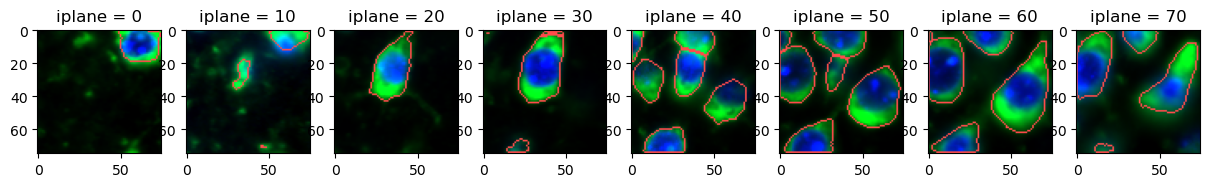

In [7]:
# DISPLAY RESULTS 3D flows => masks
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

Results from stitching

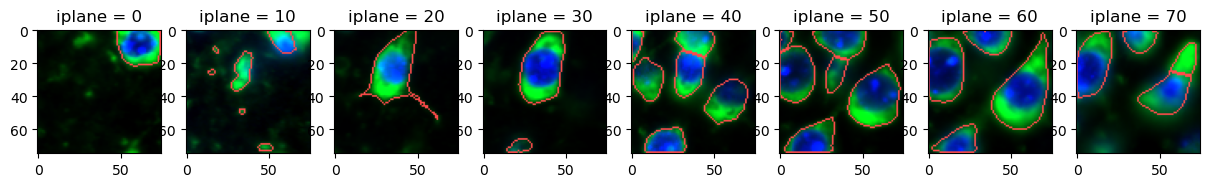

In [8]:
# DISPLAY RESULTS stitching
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks_stitched[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

## Apply to Selma data

model_type argument is not used in v4.0.1+. Ignoring this argument...


Image shape: (96, 96, 96)
GT mask shape: (96, 96, 96)
3D Cellpose output shape: (96, 96, 96)


no seeds found in get_masks_torch - no masks found.
100%|██████████| 95/95 [00:00<00:00, 3168.41it/s]


Stitched output shape: (96, 96, 96)
Saved 3D Cellpose masks to: /midtier/paetzollab/scratch/ads4015/compare_methods/cellpose/patch_000_vol003_ch0.nii_cellpose_3d.nii.gz
Saved 2D+stitch Cellpose masks to: /midtier/paetzollab/scratch/ads4015/compare_methods/cellpose/patch_000_vol003_ch0.nii_cellpose_2dstitch.nii.gz


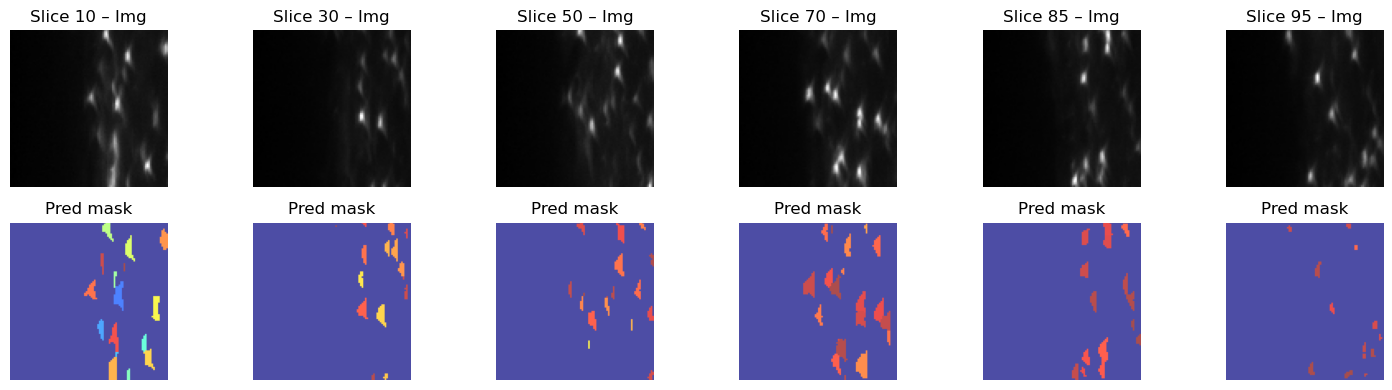

In [2]:
from pathlib import Path
import nibabel as nib
import numpy as np
from cellpose import models, utils, io, plot
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Paths
# ---------------------------------------------------
img_path = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches/cell_nucleus_patches/patch_000_vol003_ch0.nii.gz"
lab_path = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches/cell_nucleus_patches/patch_000_vol003_ch0_label.nii.gz"

out_root = Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellpose")
out_root.mkdir(parents=True, exist_ok=True)


# ---------------------------------------------------
# Load your image + label
# ---------------------------------------------------
img_nii = nib.load(img_path)
img = img_nii.get_fdata().astype(np.float32)     # shape (96,96,96)

gt_nii = nib.load(lab_path)
gt_mask = gt_nii.get_fdata().astype(np.int32)

affine = img_nii.affine
header = img_nii.header

print("Image shape:", img.shape)
print("GT mask shape:", gt_mask.shape)

# Normalize the image
img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)


# ---------------------------------------------------
# Create Cellpose model
# ---------------------------------------------------
model = models.CellposeModel(gpu=True, model_type="nuclei")  
# model_type can be "cyto", "nuclei", or "bact"

# ---------------------------------------------------
# 1. TRUE 3-D Cellpose (recommended to test)
# ---------------------------------------------------
masks3d, flows3d, _ = model.eval(
    img_norm,
    do_3D=True,
    z_axis=0,          # because your array is (Z,Y,X)
    channel_axis=None, # single channel
    batch_size=16,
    flow3D_smooth=1
)

print("3D Cellpose output shape:", masks3d.shape)

# ---------------------------------------------------
# 2. 2-D Cellpose per-slice + 3-D stitching
# ---------------------------------------------------
masks_stitched, flows_stitched, _ = model.eval(
    img_norm,
    do_3D=False,
    stitch_threshold=0.5,
    z_axis=0,
    channel_axis=None
)

print("Stitched output shape:", masks_stitched.shape)

# ---------------------------------------------------
# Save predictions as NIfTI (.nii.gz)
# ---------------------------------------------------

# Ensure integer type for masks
masks3d_nii = nib.Nifti1Image(masks3d.astype(np.int16), affine, header)
masks_stitched_nii = nib.Nifti1Image(masks_stitched.astype(np.int16), affine, header)

# Build filenames based on input name
in_name = Path(img_path).stem  # "patch_000_vol003_ch0" (strip .nii.gz)
out_3d_path = out_root / f"{in_name}_cellpose_3d.nii.gz"
out_stitch_path = out_root / f"{in_name}_cellpose_2dstitch.nii.gz"

nib.save(masks3d_nii, out_3d_path)
nib.save(masks_stitched_nii, out_stitch_path)

print("Saved 3D Cellpose masks to:", out_3d_path)
print("Saved 2D+stitch Cellpose masks to:", out_stitch_path)


# ---------------------------------------------------
# Visualization (example: 6 slices)
# ---------------------------------------------------
plt.figure(figsize=(15,4))
slices = [10, 30, 50, 70, 85, 95]

for i, z in enumerate(slices):
    img2d = img_norm[z]
    pred_mask = masks3d[z]

    plt.subplot(2, len(slices), i+1)
    plt.title(f"Slice {z} – Img")
    plt.imshow(img2d, cmap="gray")
    plt.axis("off")

    plt.subplot(2, len(slices), len(slices)+i+1)
    plt.title("Pred mask")
    plt.imshow(pred_mask, cmap="jet", alpha=0.7)
    plt.axis("off")

plt.tight_layout()
plt.show()
